## GENERATIVE AI - Assignment 3
## Roll No : 21L-6260
## Name : Zain Al Abidin

# Importing Libraries

In [54]:
!pip install datasets
!pip install --upgrade transformers
!pip install --upgrade bitsandbytes
!pip install accelerate
!pip install peft

In [55]:
import numpy as np
import os
import time
import torch
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from peft import LoraConfig,get_peft_model,TaskType,IA3Config
from transformers import (
    RobertaForSequenceClassification,
    RobertaTokenizerFast,
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoModelForCausalLM,
    DataCollatorWithPadding
)



In [56]:
# Deviceee
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model_name = "roberta-base"
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

# tokenizer
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

# Directories for model saving
output_dir_full = "Full-ft"
output_dir_lora="lora-ft"
output_dir_qlora="qlora-ft"
output_dir_ia3 ="ia3-ft"

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Part 1


## Basic Processing of Data

In [25]:
dataset = load_dataset("jingjietan/imdb-sentiment")
train_dataset = dataset["train"].select(range(3000))
test_dataset = dataset["test"].select(range(2000))

In [26]:
train_dataset

Dataset({
    features: ['review', 'sentiment', '__index_level_0__'],
    num_rows: 3000
})

In [27]:
def clean_columns(ds):
    return (ds.rename_column("sentiment", "labels").rename_column("review", "text").remove_columns(["__index_level_0__"]))

train_ds = clean_columns(train_dataset)
test_ds  = clean_columns(test_dataset)
print(train_ds)

Dataset({
    features: ['text', 'labels'],
    num_rows: 3000
})


In [28]:
train_df = pd.DataFrame(train_ds)
test_df = pd.DataFrame(test_ds)

print("Training DataFrame:")
print(train_df.head())

Training DataFrame:
                                                text  labels
0  This short film (and the poem which is behind ...       1
1  A BUSTER KEATON Silent Short.<br /><br />Poor ...       1
2  It's not too bad a b movie, with Sanders, Barr...       1
3  Feisty Dianna Jackson (a winningly spunky perf...       1
4  many people have said that this movie was not ...       1


In [29]:
print("\nTesting DataFrame:")
print(test_df.head())


Testing DataFrame:
                                                text  labels
0  A while back I bought the Chinese box set of F...       1
1  "Milo" is yet another answer to a question nob...       0
2  I'm not to keen on The Pallbearer, it's not to...       0
3  Okay wait let me get this street, there are ac...       0
4  This is sweet. The actress who played the nurs...       1


In [30]:
train_df['labels'].value_counts()

,count
labels,
0,1506
1,1494


In [31]:
test_df['labels'].value_counts()

,count
labels,
0,1056
1,944


## Tokenization

In [32]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True,max_length=512)


In [33]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format( "torch", columns=["input_ids", "attention_mask", "labels"])

# Part 2+3 - Training and Evaluation

## Method 1: Full Fine-Tuning

### Method 1 - Training



In [37]:
#Training Arguments
training_args = TrainingArguments(
    output_dir=output_dir_full,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    fp16=True,
    save_strategy="no",
    logging_strategy="no",
    report_to="none",
)


if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)


In [38]:
#Train & measure time
start_time = time.time()
trainer.train()
full_ft_train_time = time.time() - start_time

#Peak GPU memory
if torch.cuda.is_available():
    full_ft_peak_mem_bytes = torch.cuda.max_memory_allocated()
    full_ft_peak_mem_gb    = full_ft_peak_mem_bytes / 1024**3
else:
    full_ft_peak_mem_gb = 0.0

full_ft_num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

Step,Training Loss


### Method 1 - Evaluation

Test Accuracy:           0.8980
Trainable Parameters:    124,647,170 (124.65M)
Training Time (s):       428.9
Peak GPU Memory (GB):    3.24


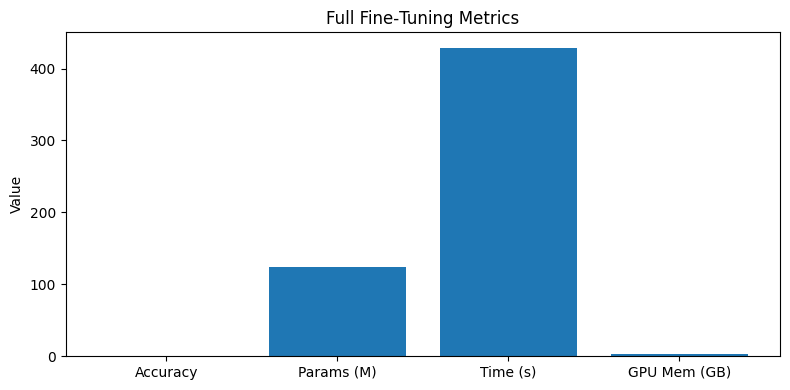

In [39]:
#Evaluate on test set
eval_metrics = trainer.evaluate(eval_dataset=test_ds)
full_ft_acc     = eval_metrics["eval_accuracy"]

#Print metrics
print(f"Test Accuracy:           {full_ft_acc:.4f}")
print(f"Trainable Parameters:    {full_ft_num_trainable:,} ({full_ft_num_trainable/1e6:.2f}M)")
print(f"Training Time (s):       {full_ft_train_time:.1f}")
print(f"Peak GPU Memory (GB):    {full_ft_peak_mem_gb:.2f}")

#visualization
metrics = {
    "Accuracy":         full_ft_acc,
    "Params (M)":       full_ft_num_trainable / 1e6,
    "Time (s)":         full_ft_train_time,
    "GPU Mem (GB)":     full_ft_peak_mem_gb,
}
plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylabel("Value")
plt.title("Full Fine‑Tuning Metrics")
plt.tight_layout()
plt.show()

## Method 2: LoRA Fine-Tuning using PEFT

### Method 2 - Training

In [57]:
# LORA CONFIGURATION
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,      # sequence classification
    inference_mode=False,            # training mode
    r=16,                            # LoRA rank
    lora_alpha=32,                   # LoRA scaling
    lora_dropout=0.05,               # dropout on LoRA weights
    bias="none",
    modules_to_save=[],
)

In [58]:
#loading model
model = get_peft_model(model, lora_config)

training_args = TrainingArguments(
    output_dir=output_dir_lora,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    fp16=True,
    save_strategy="no",
    logging_strategy="no",
    report_to="none",
)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [59]:
# Train & time
start_time = time.time()
trainer.train()
lora_train_time = time.time() - start_time

if torch.cuda.is_available():
    lora_peak_mem_bytes = torch.cuda.max_memory_allocated()
    lora_peak_mem_gb    = lora_peak_mem_bytes / 1024**3
else:
    lora_peak_mem_gb = 0.0
lora_num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

Step,Training Loss


### Method 2 - Evaluatation

Test Accuracy:           0.9415
Trainable Parameters:    1,181,954 (1.18M)
Training Time (s):       327.4
Peak GPU Memory (GB):    2.41


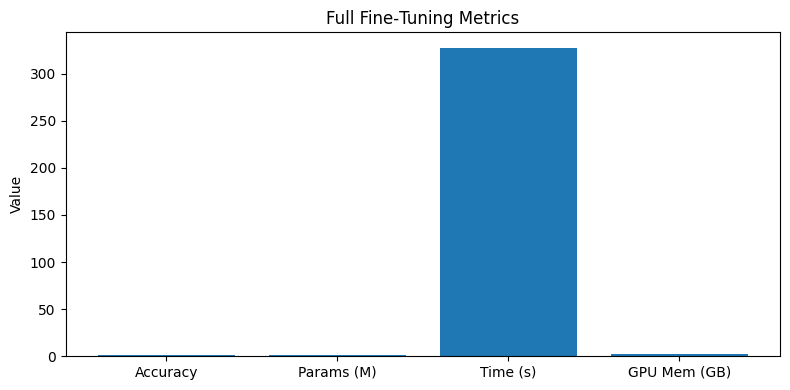

In [60]:
eval_metrics = trainer.evaluate(eval_dataset=test_ds)
lora_test_acc     = eval_metrics["eval_accuracy"]

#Print metrics
print(f"Test Accuracy:           {lora_test_acc:.4f}")
print(f"Trainable Parameters:    {lora_num_trainable:,} ({lora_num_trainable/1e6:.2f}M)")
print(f"Training Time (s):       {lora_train_time:.1f}")
print(f"Peak GPU Memory (GB):    {lora_peak_mem_gb:.2f}")

#visualization
metrics = {
    "Accuracy":         lora_test_acc,
    "Params (M)":       lora_num_trainable / 1e6,
    "Time (s)":         lora_train_time,
    "GPU Mem (GB)":     lora_peak_mem_gb,
}
plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylabel("Value")
plt.title("Full Fine‑Tuning Metrics")
plt.tight_layout()
plt.show()

##  Method 3: QLoRA Fine-Tuning

### Method 3 - Training

In [61]:
# Model QLora
model = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#QLoRA Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_skip_modules=["classifier"],
)

#Load Quantized Model
model = AutoModelForSequenceClassification.from_pretrained(
    model,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear4bit(in_features=768, out_features=768, bias=True)
              (key): Linear4bit(in_features=768, out_features=768, bias=True)
              (value): Linear4bit(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear4bit(in_features=768, out_features=768, bias

In [62]:

#LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "value"],
    bias="none",
    # modules_to_save=["classifier"],
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 1,181,954 || all params: 125,829,124 || trainable%: 0.9393


In [63]:
#Training Arguments
training_args = TrainingArguments(
    output_dir=output_dir_qlora,
    bf16=True,
    fp16=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=1e-4,
    weight_decay=0.01,
)

#Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-63-f8342cbb6d19>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [64]:
#Train
start = time.time()
trainer.train()
qlora_train_time = time.time() - start

qlora_peak_mem_gb = torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0.0

qlora_num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aceop786 (aceop786-fast-nuces) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.313900


### Method 3 - Evaluatation

Test Accuracy:           0.9385
Trainable Parameters:    1,181,954 (1.18M)
Training Time (s):       1694.9
Peak GPU Memory (GB):    10.20


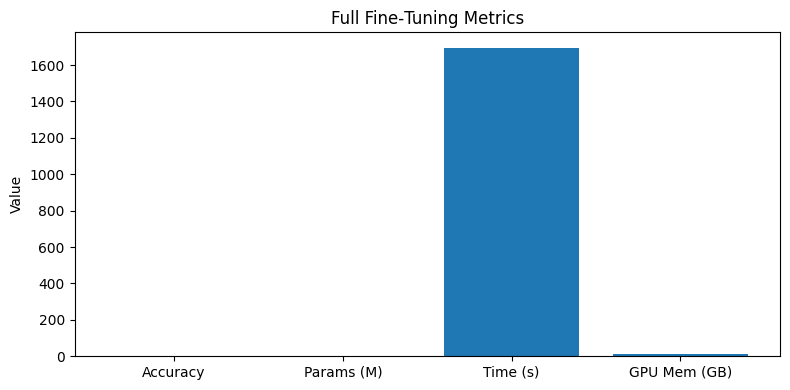

In [65]:
eval_metrics = trainer.evaluate(eval_dataset=test_ds)
qlora_test_acc     = eval_metrics["eval_accuracy"]

#Print metrics
print(f"Test Accuracy:           {qlora_test_acc:.4f}")
print(f"Trainable Parameters:    {qlora_num_trainable:,} ({qlora_num_trainable/1e6:.2f}M)")
print(f"Training Time (s):       {qlora_train_time:.1f}")
print(f"Peak GPU Memory (GB):    {qlora_peak_mem_gb:.2f}")

#visualization
metrics = {
    "Accuracy":         qlora_test_acc,
    "Params (M)":       qlora_num_trainable / 1e6,
    "Time (s)":         qlora_train_time,
    "GPU Mem (GB)":     qlora_peak_mem_gb,
}
plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylabel("Value")
plt.title("Full Fine‑Tuning Metrics")
plt.tight_layout()
plt.show()

## Method 4: Adapter Tuning (IA3)

### Method 4 - Training

In [66]:
# MODEL CONFIGG

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to("cuda")
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

#IA3 Adapters
ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False
)
model = get_peft_model(model, ia3_config).to("cuda")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
#trainable parameters
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters after adapter tuning: {num_trainable:,} ({num_trainable/1e6:.2f}M)")

#Training Arguments
training_args = TrainingArguments(
    output_dir="roberta-ia3-finetune",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    fp16=True,
    logging_strategy="no",
    save_strategy="no",
    label_names=["labels"]
)
#GPU
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()


Trainable parameters after adapter tuning: 656,642 (0.66M)


In [68]:
#Train the Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

start = time.time()
trainer.train()
ia3_train_time = time.time() - start

if torch.cuda.is_available():
    ia3_peak_mem_gb = torch.cuda.max_memory_allocated() / 1024**3
else:
    ia3_peak_mem_gb = 0.0

ia3_num_trainable = model.print_trainable_parameters()

Step,Training Loss


trainable params: 656,642 || all params: 125,303,812 || trainable%: 0.5240


### Method 4 - Evaluation

Test Accuracy:           0.9010
Trainable Parameters:    656,642 (0.66M)
Training Time (s):       397.3
Peak GPU Memory (GB):    3.24


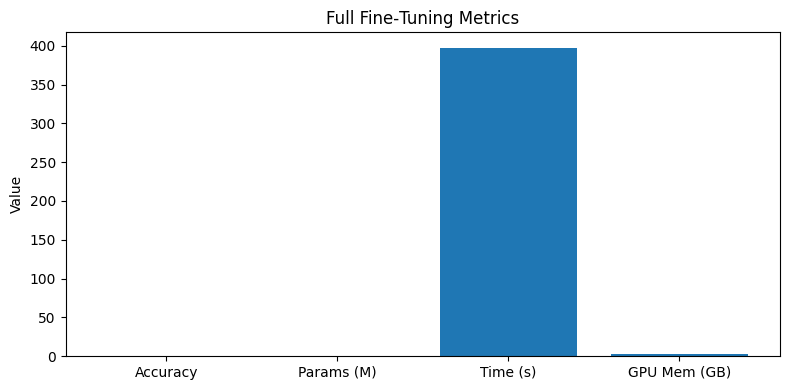

In [69]:
eval_metrics = trainer.evaluate(eval_dataset=test_ds)
ia3_test_acc     = eval_metrics["eval_accuracy"]
ia3_num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
#Print metrics
print(f"Test Accuracy:           {ia3_test_acc:.4f}")
print(f"Trainable Parameters:    {ia3_num_trainable:,} ({ia3_num_trainable/1e6:.2f}M)")
print(f"Training Time (s):       {ia3_train_time:.1f}")
print(f"Peak GPU Memory (GB):    {ia3_peak_mem_gb:.2f}")

#visualization
metrics = {
    "Accuracy":         ia3_test_acc,
    "Params (M)":       ia3_num_trainable / 1e6,
    "Time (s)":         ia3_train_time,
    "GPU Mem (GB)":     ia3_peak_mem_gb,
}
plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylabel("Value")
plt.title("Full Fine‑Tuning Metrics")
plt.tight_layout()
plt.show()

# Part 4: Visualization

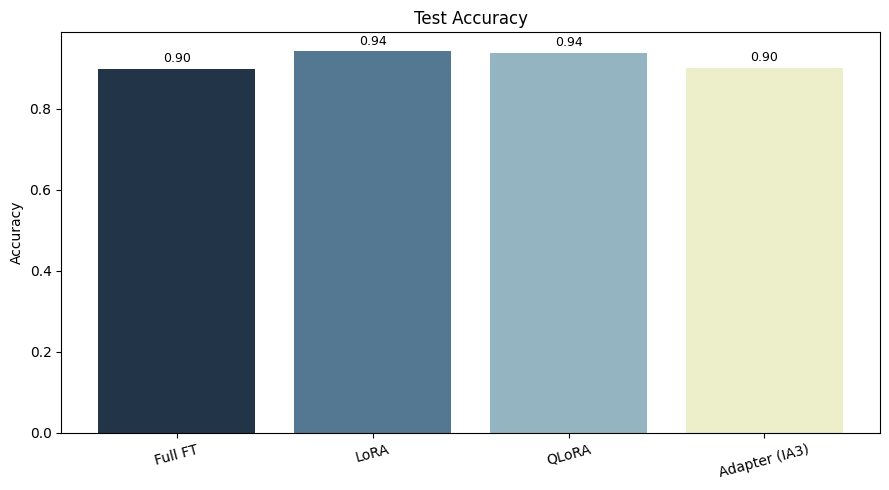

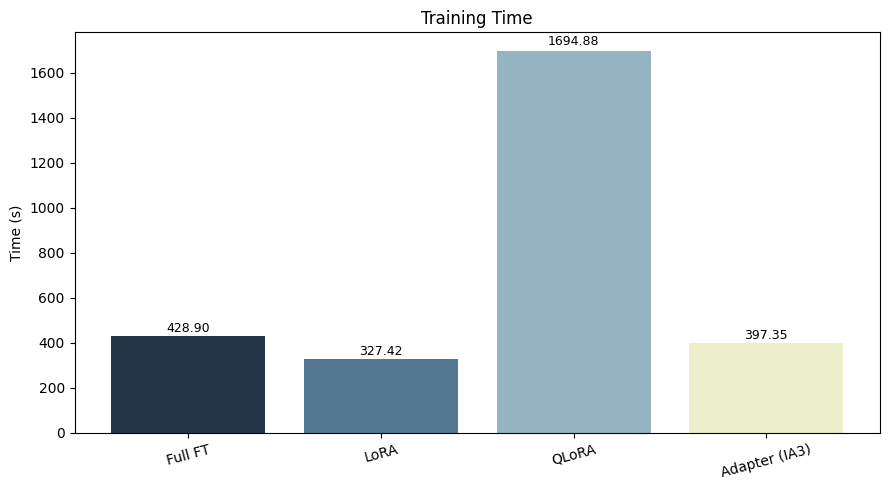

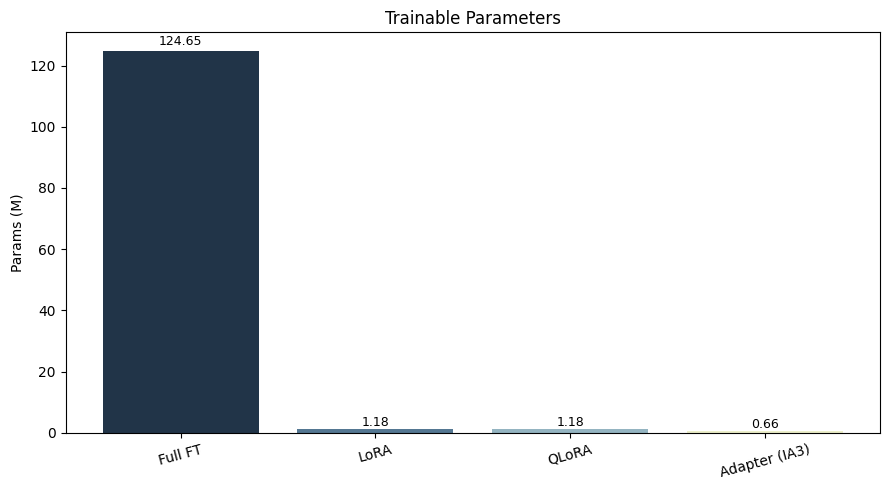

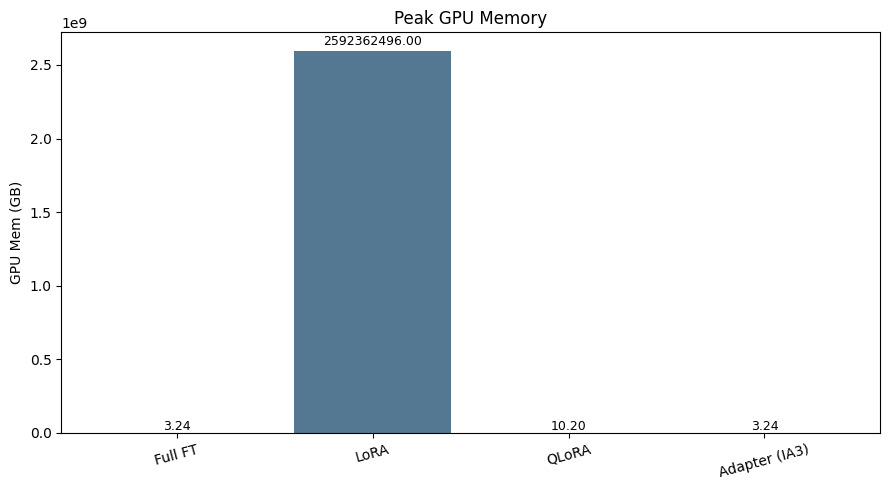

In [77]:
methods = ["Full FT", "LoRA", "QLoRA", "Adapter (IA3)"]
accs    = [full_ft_acc, lora_test_acc, qlora_test_acc, ia3_test_acc]
times   = [full_ft_train_time, lora_train_time, qlora_train_time, ia3_train_time]
params  = [full_ft_num_trainable / 1e6, lora_num_trainable / 1e6, qlora_num_trainable / 1e6, ia3_num_trainable / 1e6]
mems    = [full_ft_peak_mem_gb, lora_peak_mem_bytes, qlora_peak_mem_gb, ia3_peak_mem_gb]

def plot_metric(values, ylabel, title):
    fig, ax = plt.subplots(figsize=(9, 5))
    x = range(len(values))
    ax.bar(x, values, color=["#213448", "#547792", "#94B4C1", "#ECEFCA"])
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=15)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    for i, v in enumerate(values):
        ax.text(i, v * 1.01, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

plot_metric(accs,   "Accuracy",        "Test Accuracy")
plot_metric(times,  "Time (s)",        "Training Time")
plot_metric(params, "Params (M)",      "Trainable Parameters")
plot_metric(mems,   "GPU Mem (GB)",    "Peak GPU Memory")